# tinyurl.com/ANLPColab2Part2
Go to "File" -> "Save a Copy in Drive..."
This lets you create your own copy of the notebook in your Google drive, and any changes you make doesn't impact the shared notebook

# **Topic Modeling using LDA**

In [ ]:
!python3 -m spacy download en_core_web_sm
#!pip install pyldavis



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Set warnings to "ignore" to keep the notebook clean
import warnings
warnings.filterwarnings("ignore")

For this exercise we will use the 20 newsgroups dataset from SKLearn. We will first load the dataset and explore its contents.

In [ ]:
from sklearn.datasets import fetch_20newsgroups # Function to download the dataset

newsgroup_data = fetch_20newsgroups() # Load the data

print(f"Data set contains the following:\n{[x for x in newsgroup_data.keys()]}")

Data set contains the following:
['data', 'filenames', 'target_names', 'target', 'DESCR']


### Convert Dataset into Dataframe

In [ ]:
import pandas as pd # Library to manipulate dataframes

df = pd.DataFrame() # Initialize a new dataframe

df["text"] = newsgroup_data.data # Extract the text
df["target"] = newsgroup_data.target # Extract the target labels

# Map the target labels to the corresponding category
df["category"] = df["target"].apply(lambda x: newsgroup_data.target_names[x])
df["filenames"] = newsgroup_data.filenames # Extract the file locations

df.head() #View the first five rows in the dataset


,text,target,category,filenames
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,/root/scikit_learn_data/20news_home/20news-byd...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,/root/scikit_learn_data/20news_home/20news-byd...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,/root/scikit_learn_data/20news_home/20news-byd...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,/root/scikit_learn_data/20news_home/20news-byd...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,/root/scikit_learn_data/20news_home/20news-byd...


In [ ]:
#To view how the text transforms, let's examine a row at each step
df.text[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

Clean the text by replacing irrelevent information with blank spaces - using regular expressions, we look for specific patterns in the text.

In [ ]:
import re # Package to use regular expressions

# Define a function to clean the input text
def clean(text):
    text = re.sub(r'\S*@\S*\s?', '', text) # Remove email ids
    text = re.sub(r'\s+', ' ', text) # Remove newline (\n)
    text = re.sub(r"\'", "", text) # Remove quotes
    # Remove the header metadata
    text = re.sub(r"(From:).*(Lines: )\d*?( )", "", text)
    return text


df["text"] = df["text"].apply(clean) # Apply function to all the rows
df.head()

,text,target,category,filenames
0,I was wondering if anyone out there could enli...,7,rec.autos,/root/scikit_learn_data/20news_home/20news-byd...
1,NNTP-Posting-Host: carson.u.washington.edu A f...,4,comp.sys.mac.hardware,/root/scikit_learn_data/20news_home/20news-byd...
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware,/root/scikit_learn_data/20news_home/20news-byd...
3,Distribution: world NNTP-Posting-Host: amber.s...,1,comp.graphics,/root/scikit_learn_data/20news_home/20news-byd...
4,From article by (Tom A Baker): >>In article (P...,14,sci.space,/root/scikit_learn_data/20news_home/20news-byd...


In [ ]:
df.text[0]

'I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- '

There are two packages to demonstrate the use of LDA for topic modeling:

1. Gensim: https://radimrehurek.com/gensim/intro.html
2. Sci-kit learn (SKLearn): https://scikit-learn.org/stable/index.html

We will use Gensim package in class

# LDA using Gensim

## Let's use a library called Gensim for topic modeling. We start with text preprocessing over a number of steps as shown below:

### Tokenization

In [ ]:
# Import function to convert a document into a list of tokens
# This lowercases, tokenizes, and optionally de-accents the text
# The output are tokens (unicode strings)
from gensim.utils import simple_preprocess

# Function to tokenize the text
def tokenize(text):
    # Apply the simple_preprocess function
    text = simple_preprocess(str(text), deacc=True)
    return text

# Tokenize all texts and store it in a variable
tokenized_data = df["text"].apply(tokenize)

print("Sample tokenized text:")
print(" ".join(tokenized_data[0]))

Sample tokenized text:
was wondering if anyone out there could enlighten me on this car saw the other day it was door sports car looked to be from the late early it was called bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all know if anyone can tellme model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please mail thanks il brought to you by your neighborhood lerxst


### Building Bigram & Trigram Models

In [ ]:
# Function to detect phrases, based on collected collocation counts
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Collect the bigrams
bigram = Phrases(tokenized_data, min_count=3, threshold=100)
bigram_model = Phraser(bigram)

print("Sample bigrams:")
print(", ".join(list(bigram.export_phrases().keys())[:5]))

# Collect the trigrams
trigram = Phrases(bigram[tokenized_data], threshold=100)
trigram_model = Phraser(trigram)

print("Sample trigrams:")
print(", ".join(list(trigram.export_phrases().keys())[:5]))

# Function to create bigrams
def create_bigrams(text):
    return bigram_model[text]

# Function to create trigrams
def create_trigrams(text):
    return trigram_model[bigram_model[text]]

Sample bigrams:
front_bumper, nntp_posting, posting_host, host_carson, carson_washington
Sample trigrams:
front_bumper, nntp_posting, host_carson, nntp_posting_host_carson, washington_edu


### Stopword Removal

In [ ]:
import nltk # Library with access to corpora and lexical resources
# Download the required files from nltk
nltk.download('stopwords')
# Module to access stopwords list
from nltk.corpus import stopwords
# Extract the list of english stopwords
stop_words = stopwords.words('english')

# Function to remove stopwords
def remove_stopword(text):
    tokens = []
    for token in text:
        if token not in stop_words:
            # If the token is not in the list of stopwords
            # then keep it, else discard it
            tokens.append(token)
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Lemmatization

In [ ]:
import spacy # Library for NLP
# Load the spacy trained pipeline to tokenize the text
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function to lemmatize the tokens
def lemmatize(tokens, allowed_postags=["NOUN", "ADJ", "VERB"]):
    text = " ".join(tokens)
    text = nlp(text)
    lemmatized_tokens = []

    for token in text:
        if token.pos_ in allowed_postags:
            lemmatized_tokens.append(token.lemma_)

    return lemmatized_tokens

### Building the Corpus

In [ ]:
from tqdm import tqdm # Function to display progress bars

# Apply function to remove the stopwords
tokenized_data = [remove_stopword(text) for text in tokenized_data]

# Create the bigrams
bigram_data = [create_bigrams(text) for text in tokenized_data]

# Lemmatize the text
lemmatized_data = [lemmatize(text) for text in bigram_data]

In [ ]:
# Print the lemmatized data
print("Lemmatized data:")
print(f"1. {' '.join(lemmatized_data[0])}")
print(f"2. {' '.join(lemmatized_data[1])}")
print(f"3. {' '.join(lemmatized_data[2])}")

Lemmatized data:
1. wonder enlighten car see day door sport car look call door small addition separate rest body know model name engine spec year production car make history info funky look car mail thank bring neighborhood lerxst
2. nntp_poste fair number brave soul upgrade clock_oscillator share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat_sink hour usage day floppy_disk functionality floppy request summarize day add network knowledge base do clock upgrade answer poll thank
3. folk give ghost weekend start life sooo m market new machine bit intend m look pick powerbook bunch question answer know dirt next round powerbook introduction expect hear suppose make appearence summer hear access macleak wonder info heard_rumor price drop powerbook line one duos go s impression display swing get disk feel well display yea look great store good solicit opinion people use day day worth take disk size money hit get active di

In [ ]:
# This module implements the concept of a Dictionary
# i.e. a mapping between words and their integer ids
from gensim.corpora import Dictionary

# Create a dictionary
dictionary = Dictionary(lemmatized_data)

# Print sample mapping
keys = list(dictionary.token2id.keys())[:5]
vals = list(dictionary.token2id.values())[:5]
print("Sample dictionary mapping:")
for (key, val) in zip(keys, vals):
    print(f"{key} => {val}")

Sample dictionary mapping:
addition => 0
body => 1
bring => 2
call => 3
car => 4


In [ ]:
# Build a corpus for the topic model

# Convert the document into a Bag-Of-Words format by producing
# a list of tuples in (token_id, token_count) format
corpus = [dictionary.doc2bow(text) for text in lemmatized_data]

# Print a sample from the created corpus
print(f"Text: {' '.join(lemmatized_data[0])}")
print(f"Corpus: {corpus[0]}")

Text: wonder enlighten car see day door sport car look call door small addition separate rest body know model name engine spec year production car make history info funky look car mail thank bring neighborhood lerxst
Corpus: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


### Creating the Model

In [ ]:
# Module to train and use the Latent Dirichlet Allocation model
from gensim.models.ldamodel import LdaModel

# Initialize the model with the corpus and dictionary - this will take a while to run, be patient!
lda_model = LdaModel(
   corpus=corpus, id2word=dictionary, num_topics=20,
   random_state=100, update_every=1, chunksize=100,
   passes=10, alpha='auto', per_word_topics=True
)

#You may fine tune parameters from the documentation here: https://radimrehurek.com/gensim/models/ldamodel.html. Try them out.

In [ ]:
# Save the model

lda_model.save("lda_model") # Save the model as lda_model
del lda_model # Delete the model and free up the space used by it

In [ ]:
# Load the model
lda_model = LdaModel.load("lda_model") # Load it by passing the name

### Visualize with pyLDAvis

In [ ]:
import pyLDAvis # Module for interactive topic model visualization
# Function to prepare LDA model for visualiztion
from pyLDAvis.gensim import prepare

# Enable the display of visualizations in IPython Notebooks
pyLDAvis.enable_notebook()

# Prepare and transform and LDA model
pyLDAvis_data = prepare(lda_model, corpus, dictionary)

In [ ]:
pyLDAvis.display(pyLDAvis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Term frequency Inverse Document Frequency (Tf-Idf) for topic modeling


### Let's try re-doing topic modeling using tf-idf instead of word counts in the DTM and create other visualisations!

Topics:
Topic: 0 
Words: 0.002*"get" + 0.002*"go" + 0.002*"think" + 0.002*"use" + 0.002*"know" + 0.002*"good" + 0.001*"say" + 0.001*"game" + 0.001*"people" + 0.001*"believe"

Topic: 1 
Words: 0.003*"card" + 0.002*"get" + 0.002*"driver" + 0.002*"scsi" + 0.002*"thank" + 0.002*"drive" + 0.002*"use" + 0.002*"gun" + 0.002*"article" + 0.002*"time"

Topic: 2 
Words: 0.002*"window" + 0.002*"key" + 0.002*"use" + 0.002*"get" + 0.002*"package" + 0.002*"make" + 0.002*"system" + 0.002*"say" + 0.002*"know" + 0.002*"character"

Topic: 3 
Words: 0.002*"pointer" + 0.002*"duo" + 0.002*"get" + 0.002*"use" + 0.001*"know" + 0.001*"system" + 0.001*"problem" + 0.001*"thank" + 0.001*"window" + 0.001*"program"

Topic: 4 
Words: 0.002*"m" + 0.002*"car" + 0.002*"window" + 0.002*"thank" + 0.002*"use" + 0.001*"think" + 0.001*"article" + 0.001*"write" + 0.001*"know" + 0.001*"game"

Topic: 5 
Words: 0.002*"team" + 0.002*"game" + 0.001*"use" + 0.001*"go" + 0.001*"nhl" + 0.001*"key" + 0.001*"think" + 0.001*"say" + 0.0

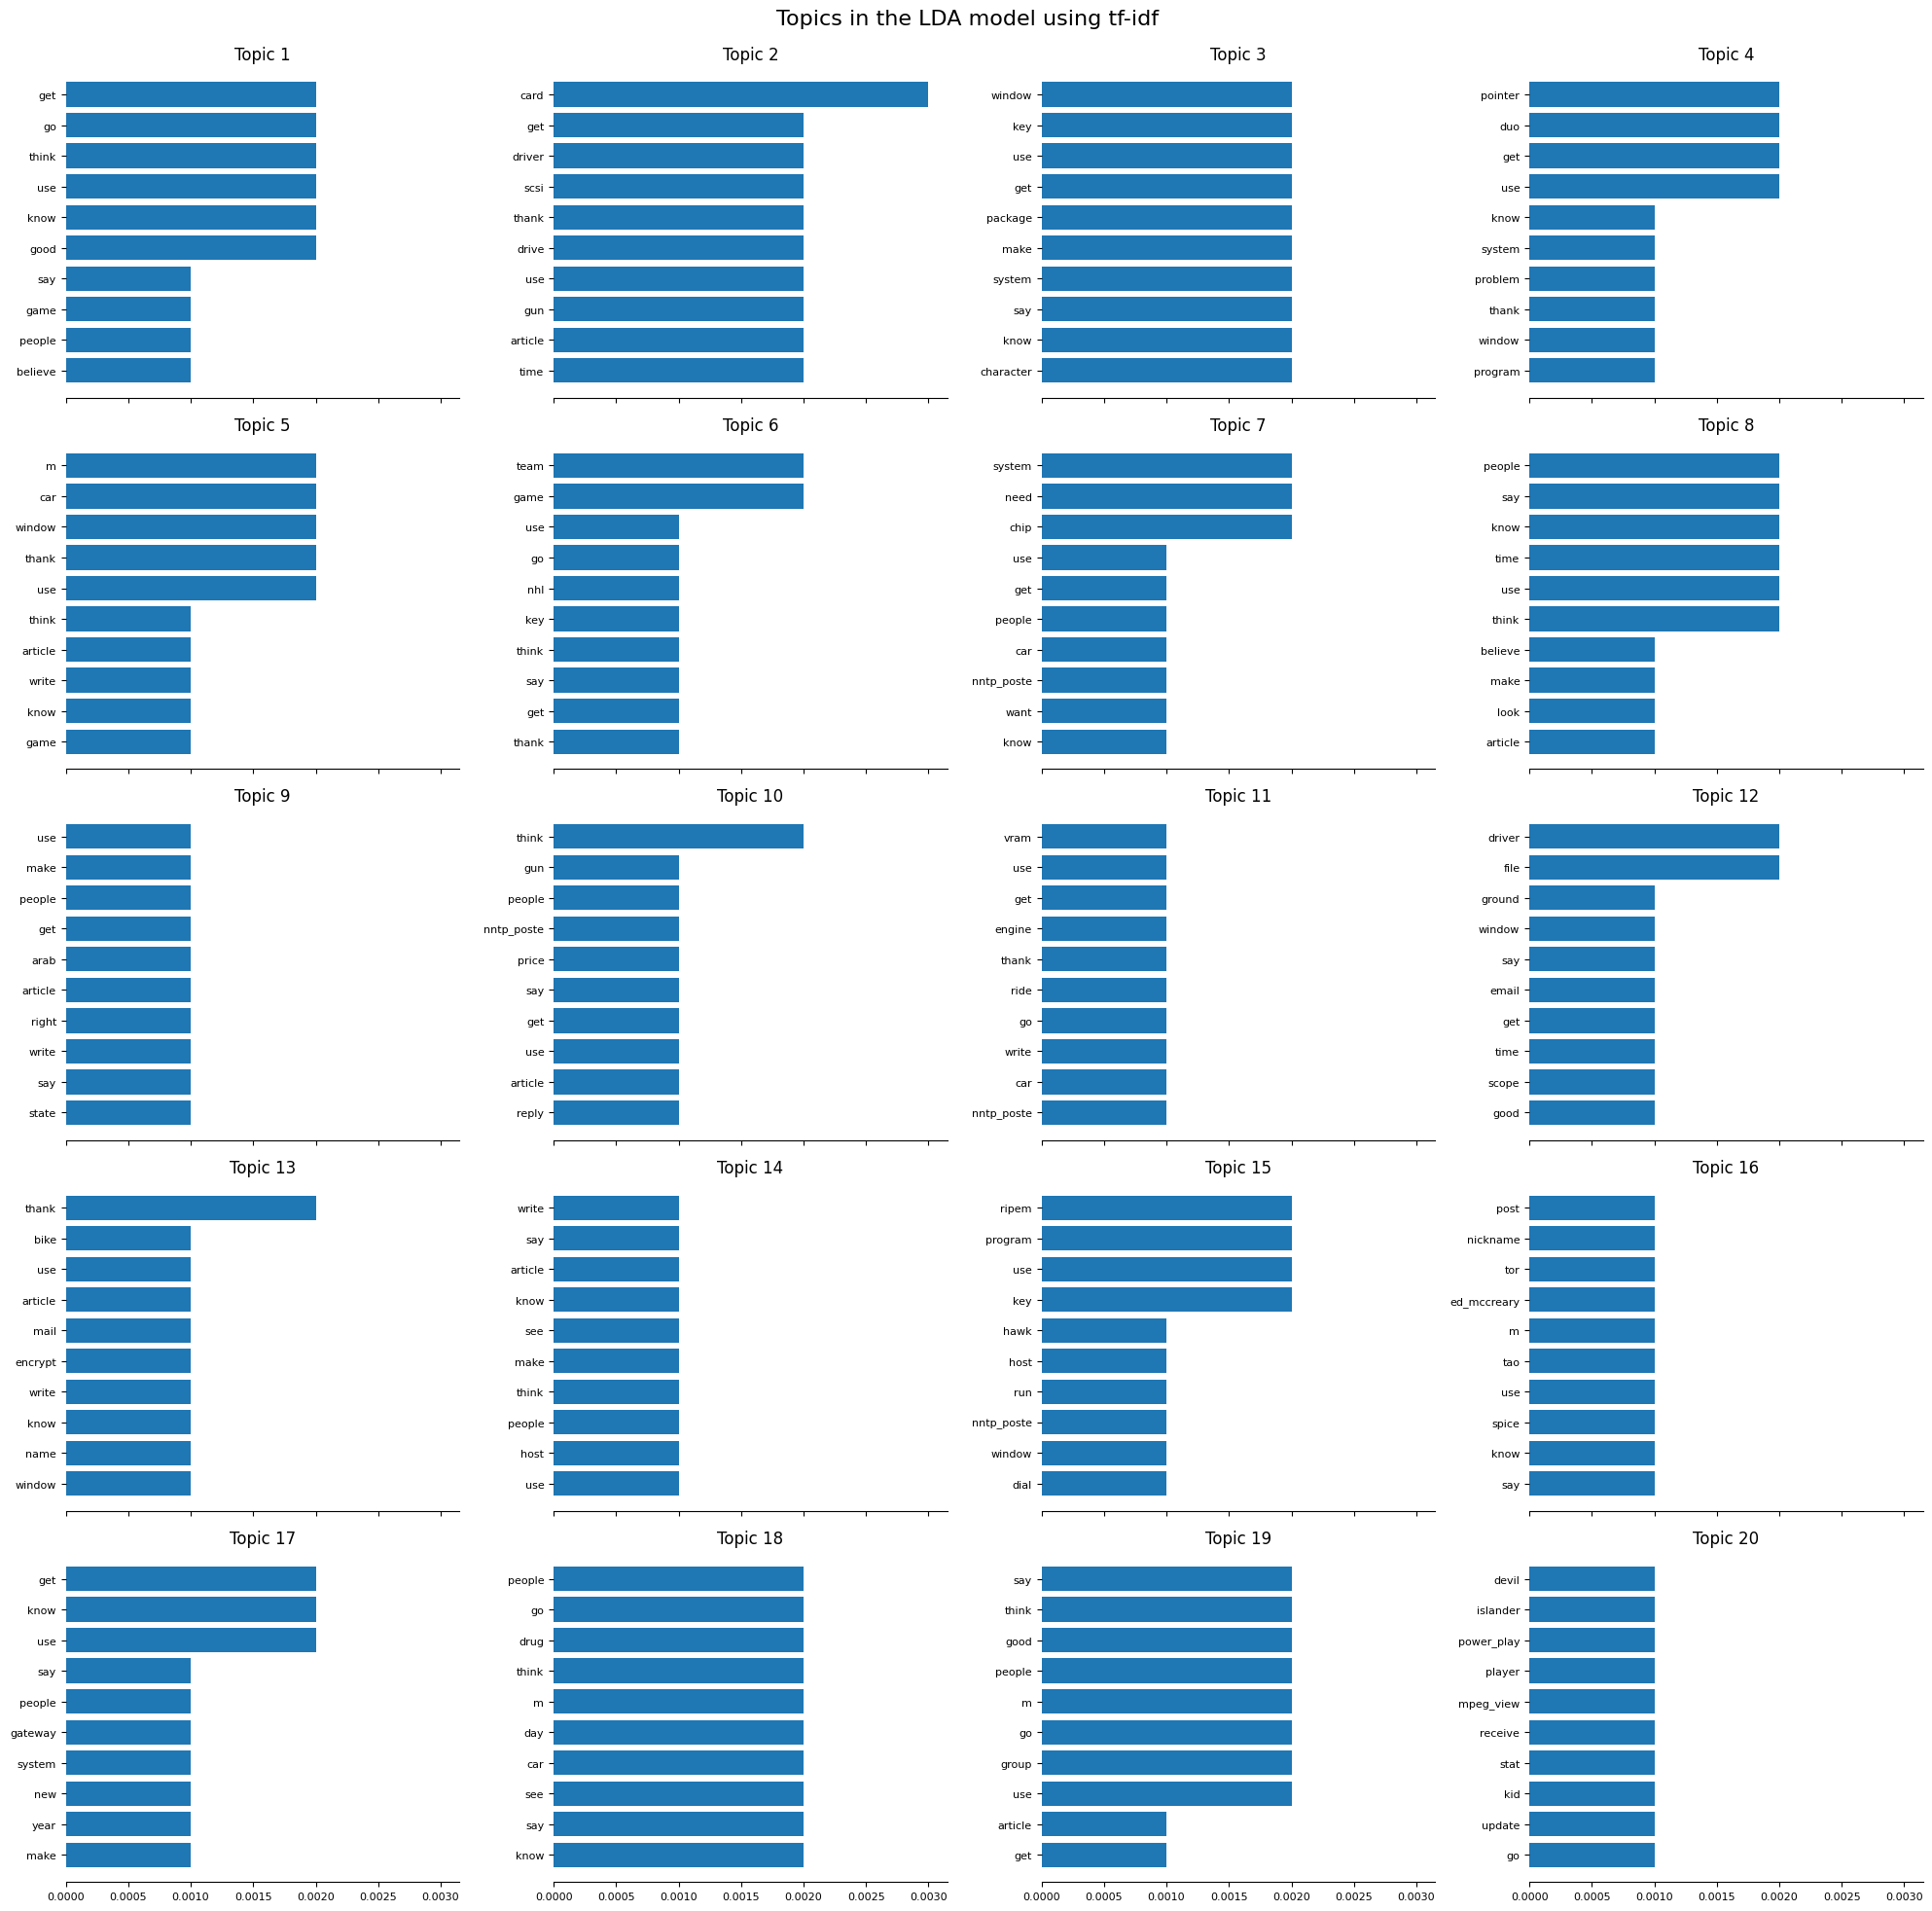

       Dominant_Topic  Perc_Contribution  \
0                  17             0.7381   
1                   7             0.6432   
2                  17             0.8808   
3                   6             0.6801   
4                   7             0.5719   
...               ...                ...   
11309               7             0.5637   
11310               8             0.3854   
11311              16             0.4028   
11312              13             0.5364   
11313              12             0.3441   

                                          Topic_Keywords  index  \
0      people, go, drug, think, m, day, car, see, say...      0   
1      people, say, know, time, use, think, believe, ...      1   
2      people, go, drug, think, m, day, car, see, say...      2   
3      system, need, chip, use, get, people, car, nnt...      3   
4      people, say, know, time, use, think, believe, ...      4   
...                                                  ...    ...   
11

In [ ]:
from gensim.models import LdaMulticore
from gensim.models import TfidfModel
import matplotlib.pyplot as plt
import math

# Create TF-IDF model using the same pre-processed corpus
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Train the LDA model
num_topics = 20  # You can adjust this number
lda_model = LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics, random_state=42)

# Print the topics
print("Topics:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

# Visualize the topics in bar plots
def plot_top_words(model, feature_names, n_top_words, title):
    # Get the number of topics
    num_topics = len(model.print_topics(-1))

    # Calculate the number of rows and columns for subplots
    num_cols = min(4, num_topics)  # Maximum 4 columns
    num_rows = math.ceil(num_topics / num_cols)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows), sharex=True)
    axes = axes.flatten() if num_topics > 1 else [axes]

    for topic_idx, topic in model.print_topics(-1):
        # Use regex to extract words and weights
        words_weights = re.findall(r'(0\.\d+)\*"(.+?)"', topic)

        if words_weights:
            weights, words = zip(*words_weights)
            weights = [float(w) for w in weights]
        else:
            print(f"No matches found for topic {topic_idx}")
            continue

        ax = axes[topic_idx]
        ax.barh(words[:n_top_words], weights[:n_top_words])
        ax.set_title(f'Topic {topic_idx + 1}')
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=8)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    # Hide any unused subplots
    for idx in range(num_topics, len(axes)):
        axes[idx].set_visible(False)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to prevent title overlap
    plt.show()

plot_top_words(lda_model, dictionary.values(), n_top_words=10, title='Topics in the LDA model using tf-idf')

# Assign topics to documents
def format_topics_sentences(ldamodel, corpus):
    topics_df = []

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break

    return pd.DataFrame(topics_df, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

# Use the function
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus_tfidf)

# Combine original dataframe with the topic dataframe
df_dominant_topic = pd.concat([df_topic_sents_keywords, df.reset_index()], axis=1)
print(df_dominant_topic)